# Tutorial 3: Gaussian Process Model with Active Learning

In this notebook, we will train a Gaussian Process (GP) model using an active learning scheme. At each learning iteration, this scheme enriches the training dataset with one sample such that the current GP model makes the largest expected prediction error at that sample.

For a theoretical introduction of this active learning, please check out this blog post in Towards Data Science: [Reducing Model Training Cost With Active Learning](https://towardsdatascience.com/reducing-model-training-cost-with-active-learning-255b40a2aa98). 

If you have further questions, please contact Shuai Guo at guo@tfd.mw.tum.de

In [1]:
# Set module path
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\GaussianProcess")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyDOE import lhs
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Import GP interpolation module
from GPInterpolator import GPInterpolator

%matplotlib inline

## 1. 1D Test Function

We select the following test function in this case study:

\begin{equation}
y(x) = 3(1-x)^2e^{(-x^2-1)}-10(0.2x-x^3)e^{-x^2}, \; x \in [-4, 1]
\end{equation}

Later on, we will train a GP model to approximate this test function. To minimize the number of employed training samples, we will use an active learning strategy to intelligiently select one new sample at each learning iteration. Details of the active learning workflow is given in a latter section. 

For now, let's first plot this function to gain some intuition.

In [2]:
def test_function(x):
    y = 3*(1-x)**2*np.exp(-x**2-1) \
            - 10*(0.2*x-x**3)*np.exp(-x**2)
    return y

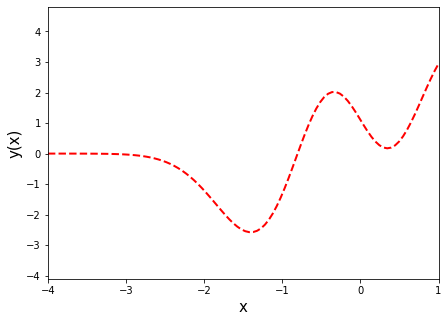

In [3]:
# Test function values
X_test = np.linspace(-4, 1, 100).reshape(-1,1)
y_test = test_function(X_test)
            

# Display test function
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_test,y_test,'r--',linewidth=2,label='Test Function')
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y(x)', fontsize=15)
ax.set_xlim([-4,1]);
ax.set_ylim([-4.1,4.8]);

From the figure above, we can see that the current test function describes a rather complex relationship between the input $x$ and the output $y(x)$: a flat region exists in the range [-4, -3], while multimodal responses dominate the remaining region. Since the correlation length varies significantly across the parameter space, it is challenging to construct a globally accurate GP model.

### 1.2 Train an initial model

We start by training an initial GP model with 5 samples spreading evenly across the parameter space. Here, we use the developed `GPInterpolator` class to train the GP model.

In [49]:
# Initial training data
X_train = np.linspace(-4, 1, 5).reshape(-1,1)
y_train = 3*(1-X_train)**2*np.exp(-X_train**2-1) \
            - 10*(0.2*X_train-X_train**3)*np.exp(-X_train**2)

It is a good practice to normalize inputs before submitting it to GP model training.  Here, we use `sklearn.Pipeline` to glue together a scaler (which scales the inputs) and our developed `GPInterpolator` class. 

In [50]:
# GP model training
pipe = Pipeline([('scaler', MinMaxScaler()), 
         ('GP', GPInterpolator(n_restarts=30))])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('GP',
                 <GPInterpolator.GPInterpolator object at 0x000001108BF45D30>)])

In [51]:
# Assess GP prediction results
def plot_GP(pipe_GP, X_test, X_train, y_train, ax):
    """Plot GP prediction results"""
    
    # GP prediction
    y_pred, y_pred_SSqr = pipe_GP.predict(X_test)
    
    # Post-processing
    fig, ax = plt.subplots(figsize=(7,5))
    
    ax.plot(X_test,y_test,'r--',lw=2,label='Test Function')
    ax.plot(X_train,y_train,'bo',markerfacecolor='b',markersize=10,label='Training Data')  
    ax.plot(X_test, y_pred,'b-', linewidth=2,label='GP Prediction')
    ax.fill_between(X_test.flatten(), y_pred-1.96*np.sqrt(y_pred_SSqr), 
                y_pred+1.96*np.sqrt(y_pred_SSqr),
                facecolor='lavender',label='95% Credibility Interval')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(loc="upper left",prop={'size': 12})
    ax.set_xlabel('x', fontsize=15)
    ax.set_ylabel('f(x)', fontsize=15)
    ax.set_xlim([-4.2,1.2]);

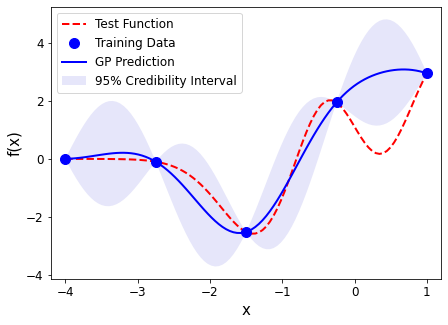

In [52]:
plot_GP(pipe, X_test, X_train, y_train, ax)

As can be seen from the figure above, the GP predictions match poorly with the true test function due to an insufficient number of training samples. In the following, we will adopt the active learning strategy discussed above to gradually enrich the training dataset and refine the GP model.

### 1.3 First iteration

Before we start iterating, we need to generate a pool of candidate samples. We will maintain this candidate pool for the subsequent iterations. At each iteration, we pick one sample from the candidate pool. This sample should yield the maximum expected prediction error value among all the candidate samples.

In [53]:
# Start active learning
iteration = 1
EPE_history = []

# Generate candidate samples (in normalized scale)
Pool = np.random.rand(10000, 1)

Now we are ready for the first iteration. 

**The following two cells can be excuted multiple times to manually control the iteration flow**. The first cell identify the sample with the maximum prediction error. The second and third cell visually summarizes the results from the current iteration and add newly identified samples to the current training dataset.

Notice that we use `.enrichment` method to select the promising training sample. Since we are looking for samples with the maximum expected prediction error (EPE), we assign `EPE` to the `condition` parameter.

In [66]:
# 1-GP model training and predicting
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)[0]
rmse_score = pipe.score(X_test, y_test)

# 2-Active learning
target, sample, org_pool, Pool, EPE = pipe['GP'].enrichment({'Condition':'EPE'}, 
                                     candidate=Pool, 
                                     diagnose=True)

# Add to EPE convergence history
EPE_history.append(target)

# 3-Display iteration info
summary = 'Iteration summary:'
iter_number = 'Current iteration: {}'.format(str(iteration))

Iteration_summary = 'Iteration {}:'.format(str(iteration)) \
                    + os.linesep \
                    + 'Current max EPE is {}'.format(str(target)) \
                    + os.linesep \
                    + 'Current MSE is {}'.format(str(rmse_score))

print(Iteration_summary)

Iteration 7:
Current max EPE is 0.08842566426102047
Current MSE is 0.005605527341557922


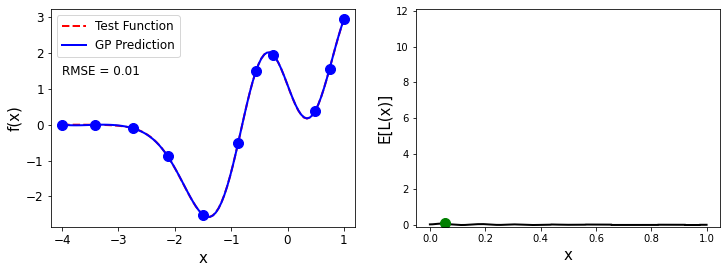

In [67]:
# 4-Iteration assessment
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(X_test,y_test,'r--',lw=2,label='Test Function')
axs[0].plot(X_train,y_train,'bo',markerfacecolor='b',markersize=10)
axs[0].plot(X_test,y_pred,'b-',lw=2,label='GP Prediction')
axs[0].text(-4, 1.4, 'RMSE = {}'.format(str(np.round_(rmse_score,2))), fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].legend(loc="upper left",prop={'size': 12})
axs[0].set_xlabel('x', fontsize=15)
axs[0].set_ylabel('f(x)', fontsize=15)
axs[0].set_xlim([-4.2,1.2]);

# EPE distribution
df = pd.DataFrame(np.c_[org_pool.reshape(-1,1), EPE], columns=["Candidates", "EPE-values"])
df = df.sort_values(by=['Candidates'])

axs[1].plot(df['Candidates'], df['EPE-values'],'k-',lw=2)
axs[1].plot(sample, target,'go',markersize=10)
axs[1].set_xlabel('x', fontsize=15)
axs[1].set_ylabel('E[L(x)]', fontsize=15)
axs[1].set_ylim([-0.1,12.1]);

# 5-Enrich training dataset
Denormalized_sample = pipe['scaler'].inverse_transform(sample)  # Sample in original scale
X_train = np.vstack((X_train, Denormalized_sample))
y_train = np.vstack((y_train, test_function(Denormalized_sample)))
iteration += 1

After 7 iterations, we can see that the maximum $E[L(x)]$ value has dropped a lot compared with the first iteration. Correspondingly, this GP model is able to make accurate predictions across the entire parameter space. 

In practice, we monitor the change of maximum $E[L(x)]$ to define when the training can be terminated. In the current case study, we require that the maximum $E[L(x)]$ has to be smaller than 5% of the maximum $E[L(x)]$ at the first iteration.

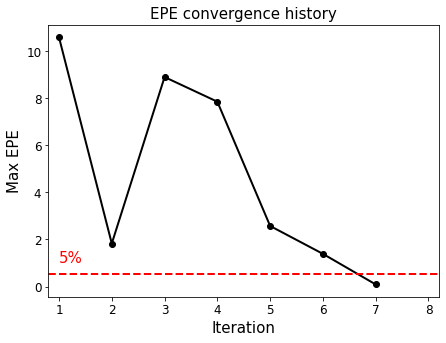

In [68]:
# EPE convergence history
fig, ax = plt.subplots(figsize=(7,5))

ax.plot(np.arange(1,iteration), EPE_history, 'k-o', lw=2)
ax.plot([0,8.3],[EPE_history[0]*0.05, EPE_history[0]*0.05],'r--',lw=2)
ax.text(1,1,'5%',fontsize=15, color='r')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Iteration', fontsize=15)
ax.set_ylabel('Max EPE', fontsize=15)
ax.set_title('EPE convergence history', fontsize=15)
ax.set_xlim([0.8, 8.2]);

## 2. Test function (2D)

We further showcase how to use active learning scheme to train a GP model for multi-dimensional problems. Here, we consider a task of approximating a two-dimensional analytical function.

\begin{equation}
y = (1-x_1)^2 + 100(x_2-x_1^2)^2, x_1 \in [-2,2] \; x_2 \in [-1,3]
\end{equation}

In [69]:
# 2D Test function
def Test_2D(X):
    """2D Test Function"""
    
    y = (1-X[:,0])**2 + 100*(X[:,1]-X[:,0]**2)**2
    
    return y

### 2.1 Training/testing dataset

We use **Latin Hypercube Sampling** approach to generate space-filling training samples. For the current case, we use the implementation from [`PyDOE`](https://pythonhosted.org/pyDOE/randomized.html#latin-hypercube) package. Alternatively, you could use [skopt.sampler](https://scikit-optimize.github.io/stable/auto_examples/sampler/initial-sampling-method.html#sphx-glr-auto-examples-sampler-initial-sampling-method-py) package. We use 13 samples to train an initial GP model.

In [70]:
# Load LHS package
from pyDOE import lhs

# Training data
sample_num = 13
lb, ub = np.array([-2, -1]), np.array([2, 3])
X_train = (ub-lb)*lhs(2, samples=sample_num) + lb

# Compute labels
y_train = Test_2D(X_train).reshape(-1,1)

# Test data
X1 = np.linspace(-2, 2, 20)
X2 = np.linspace(-1, 3, 20)
X1, X2 = np.meshgrid(X1, X2)
X_test = np.hstack((X1.reshape(-1,1), X2.reshape(-1,1)))
y_test = Test_2D(X_test)

In [71]:
# GP model training
pipe = Pipeline([('scaler', MinMaxScaler()), 
         ('GP', GPInterpolator(n_restarts=30))])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('GP',
                 <GPInterpolator.GPInterpolator object at 0x000001108BFC56A0>)])

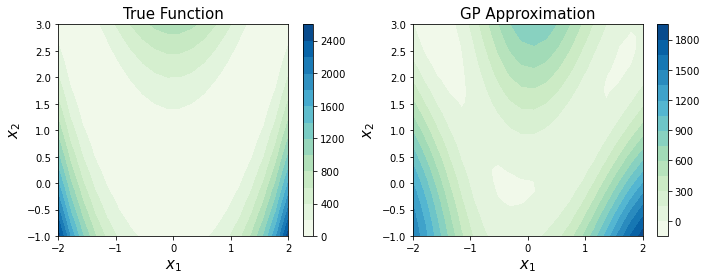

In [72]:
# GP model predicting
y_pred, y_pred_SSqr = pipe.predict(X_test)

# Post-processing - Contour plot
fig, ax = plt.subplots(1, 2, figsize=(10,4))
title = ['True Function', 'GP Approximation']
display_y = [y_test, y_pred]

for i in range(2):
    h = ax[i].contourf(X_test[:,0].reshape(20,-1), 
                   X_test[:,1].reshape(20,-1), 
                   display_y[i].reshape(20,-1), levels=15, cmap='GnBu');
    ax[i].set_xlabel(r'$x_1$', fontsize=15)
    ax[i].set_ylabel(r'$x_2$', fontsize=15)
    ax[i].set_title(title[i], fontsize=15)
    fig.colorbar(h, ax=ax[i])
plt.tight_layout()

As we can see, the prediction accuracy is not satisfactory. In the following, we use active learning to enrich the current training dataset and improve the GP model accuracy.

In [74]:
# Start active learning
iteration = 1
EPE_history = []

# Generate candidate samples
Pool = np.random.rand(10000, 2)

**The following two cells can be excuted multiple times to manually control the iteration flow**. The first cell identify the sample with the maximum prediction error. The second and third cell visually summarizes the results from the current iteration and add newly identified samples to the current training dataset.

In [87]:
# 1-GP model training and predicting
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)[0]
rmse_score = pipe.score(X_test, y_test)

# 2-Active learning
target, sample, Org_pool, Pool, EPE = pipe['GP'].enrichment({'Condition':'EPE'}, 
                                     candidate=Pool, 
                                     diagnose=True)
EPE_history.append(target)

# 3-Display iteration info
summary = 'Iteration summary:'
iter_number = 'Current iteration: {}'.format(str(iteration))

Iteration_summary = 'Iteration {}:'.format(str(iteration)) \
                    + os.linesep \
                    + 'Current max EPE is {}'.format(str(target)) \
                    + os.linesep \
                    + 'Current MSE is {}'.format(str(rmse_score))

print(Iteration_summary)

Iteration 7:
Current max EPE is 131.73079052291288
Current MSE is 2.045774212104675


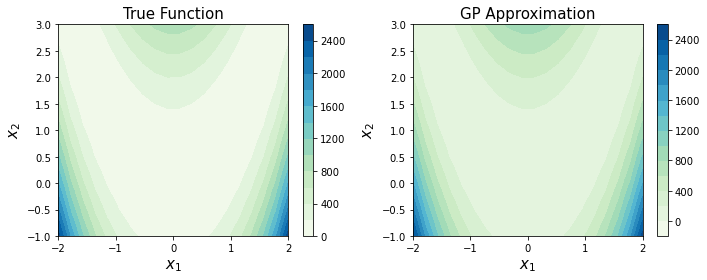

In [88]:
# 4-Iteration assessment
fig, ax = plt.subplots(1, 2, figsize=(10,4))
title = ['True Function', 'GP Approximation']
display_y = [y_test, y_pred]

for i in range(2):
    h = ax[i].contourf(X_test[:,0].reshape(20,-1), 
                   X_test[:,1].reshape(20,-1), 
                   display_y[i].reshape(20,-1), levels=15, cmap='GnBu');
    ax[i].set_xlabel(r'$x_1$', fontsize=15)
    ax[i].set_ylabel(r'$x_2$', fontsize=15)
    ax[i].set_title(title[i], fontsize=15)
    fig.colorbar(h, ax=ax[i])
plt.tight_layout()

# 5-Enrich training dataset
Denormalized_sample = pipe['scaler'].inverse_transform(sample)  # Sample in original scale
X_train = np.vstack((X_train, Denormalized_sample))
y_train = np.vstack((y_train, Test_2D(Denormalized_sample)))
iteration += 1

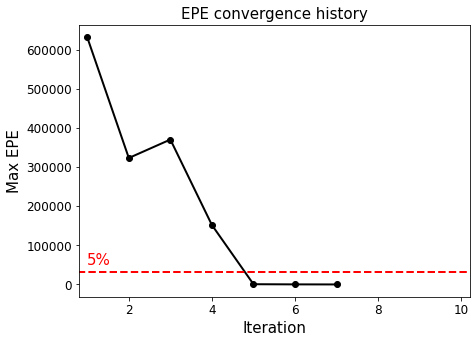

In [90]:
# EPE convergence history
fig, ax = plt.subplots(figsize=(7,5))

ax.plot(np.arange(1,iteration), EPE_history, 'k-o', lw=2)
ax.plot([0,15.3],[EPE_history[0]*0.05, EPE_history[0]*0.05],'r--',lw=2)
ax.text(1,50000,'5%',fontsize=15, color='r')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Iteration', fontsize=15)
ax.set_ylabel('Max EPE', fontsize=15)
ax.set_title('EPE convergence history', fontsize=15)
ax.set_xlim([0.8, 10.2]);